In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_es = pd.DataFrame()
for i in range(1, 12):
    df_temp = pd.read_csv(f'ES_part_{i}.csv')
    df_es = pd.concat([df_es, df_temp], ignore_index=True)

df_surprise = pd.read_csv('US_economic_releases_events.csv')

df_surprise.drop(columns=['S', 'Month', 'Surv(A)', 'Surv(H)', 'Surv(L)',], inplace=True)

df_surprise.drop(columns=['Flag', 'Country/Region', 'Day', 'C', 'Category','Subcategory', 'Std Dev', 'Period', 'Actual'])

# Dropping all rows for which surprise column has NaN or 0 value
df_surprise.dropna(subset=['Surprise'], inplace=True)
df_surprise = df_surprise[df_surprise['Surprise'] != 0]

df_surprise.replace("--", pd.NA, inplace=True)

# Redoing dropping all rows for which surprise column has NaN or 0 value
df_surprise.dropna(subset=['Surprise'], inplace=True)
df_surprise = df_surprise[df_surprise['Surprise'] != 0]

# Convert 'Surprise' column to float
df_surprise['Surprise'] = pd.to_numeric(df_surprise['Surprise'], errors='coerce')

# Again filtering out rows where 'Surprise' is 0 or NaN
df_surprise = df_surprise[df_surprise['Surprise'] != 0].dropna(subset=['Surprise'])

df_surprise.dropna(subset=['Time'], inplace=True)

# Wincorsizing to get results between 0.5% and 99.5% percentile for Surprise values
lower_bound = df_surprise['Surprise'].quantile(0.005)
upper_bound = df_surprise['Surprise'].quantile(0.995)

df_surprise = df_surprise[(df_surprise['Surprise'] >= lower_bound) & (df_surprise['Surprise'] <= upper_bound)]

# Step 1: Ensure columns are strings
df_surprise['Date'] = df_surprise['Date'].astype(str)
df_surprise['Time'] = df_surprise['Time'].astype(str)

# Step 2: Handle missing times (if any)
df_surprise['Time'] = df_surprise['Time'].fillna('00:00:00')

# Step 3: Combine Date and Time into DateTime
df_surprise['DateTime'] = pd.to_datetime(
    df_surprise['Date'].str[:10] + ' ' + df_surprise['Time'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'  # Converts invalid parsing to NaT instead of raising error
)

# First we drop Date and DateTime and change the column name for Unnamed: 0 to Date

df_surprise.drop(columns=['Date', 'DateTime'], inplace=True)
df_surprise.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Now let's again create a DateTime column with the new Date column and check for number of NaN values
# Step 1: Ensure columns are strings
df_surprise['Date'] = df_surprise['Date'].astype(str)
df_surprise['Time'] = df_surprise['Time'].astype(str)

# Step 2: Handle missing times (if any)
df_surprise['Time'] = df_surprise['Time'].fillna('00:00:00')

# Step 3: Combine Date and Time into DateTime
df_surprise['DateTime'] = pd.to_datetime(
    df_surprise['Date'].str[:10] + ' ' + df_surprise['Time'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'  # Converts invalid parsing to NaT instead of raising error
)

# Step 1: Ensure columns are strings
df_es['Date'] = df_es['Date'].astype(str)
df_es['Time'] = df_es['Time'].astype(str)

# Step 2: Handle missing times (if any) and pad with seconds
df_es['Time'] = df_es['Time'].fillna('00:00')  # Fill missing times
df_es['Time'] = df_es['Time'] + ':00'  # Add seconds to make HH:MM:SS format

# Step 3: Combine Date and Time into DateTime with correct format
df_es['DateTime'] = pd.to_datetime(
    df_es['Date'] + ' ' + df_es['Time'],
    format='%m/%d/%Y %H:%M:%S',  # Matches MM/DD/YYYY date and HH:MM:SS time
    errors='coerce'
)

# Now we create the merged dataframe for our analysis - to allow us to match times of surprise with the price of the future at the time
df_combined = pd.merge(
    df_es,
    df_surprise,
    on='DateTime',
    how='outer',
    suffixes=('_es', '_surprise'),
    indicator=True  # this shows the source of each using suffix
)

# Some surprise announcements might have come before the starting point for the data on the futures, these would be meaningless for our analysis and should thus
# be removed by removing all rows with NaN values for Open

df_combined.dropna(subset=['Open'], inplace=True)

df_combined['Surprise Occurred'] = df_combined['Surprise'].notna()


df_combined['First Post Surprise'] = df_combined['Surprise Occurred'].shift(1)
df_combined['First Post Surprise'].iloc[0] = False

df_combined

C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\3402801710.py:10: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_surprise = pd.read_csv('US_economic_releases_events.csv')
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\3402801710.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_surprise.replace("--", pd.NA, inplace=True)
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\3402801710.py:108: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the or

,Date_es,Time_es,Open,Close,Volume,DateTime,Date_surprise,Period,Event,Ticker,...,Day,Surv(M),# Ests.,Std Dev,Surprise,Country/Region,Flag,_merge,Surprise Occurred,First Post Surprise
2,09/10/1997,00:01:00,0.00,0.00,0.0,1997-09-10 00:01:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False,False
3,09/10/1997,00:02:00,0.00,0.00,0.0,1997-09-10 00:02:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False,False
4,09/10/1997,00:03:00,0.00,0.00,0.0,1997-09-10 00:03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False,False
5,09/10/1997,00:04:00,0.00,0.00,0.0,1997-09-10 00:04:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False,False
6,09/10/1997,00:05:00,0.00,0.00,0.0,1997-09-10 00:05:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9695761,12/19/2024,15:56:00,5941.75,5941.75,318.0,2024-12-19 15:56:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False,False
9695762,12/19/2024,15:57:00,5941.75,5941.50,386.0,2024-12-19 15:57:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False,False
9695763,12/19/2024,15:58:00,5941.50,5941.00,484.0,2024-12-19 15:58:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False,False
9695764,12/19/2024,15:59:00,5940.75,5941.00,6462.0,2024-12-19 15:59:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,False,False


In [118]:
holding_period = 20
transaction_cost = 0.000025

In [119]:
df_combined['N_Return'] = np.nan
df_combined['N_Return_half'] = np.nan
df_combined['N_Return_double'] = np.nan
df_combined['Return'] = np.nan
df_combined['Return_half'] = np.nan
df_combined['Return_double'] = np.nan

surprise_rows = df_combined[df_combined['First Post Surprise'] == True]

for index, row in surprise_rows.iterrows():
    row_position = df_combined.index.get_loc(index)

    # Get the Surprise value from the previous row
    if index > df_combined.index[0]:
        prev_surprise = df_combined.at[df_combined.index[df_combined.index.get_loc(index)-1], 'Surprise']
    else:
        prev_surprise = 0  # Default if no previous row exists

    if row_position + holding_period < len(df_combined):
        current_price = row['Open']
        future_row = df_combined.iloc[row_position + holding_period]
        future_price = future_row['Open']

        if current_price != 0:
            percentage_increase = (future_price - current_price) / current_price
        else:
            percentage_increase = np.nan

        df_combined.at[index, 'Return'] = percentage_increase
        if prev_surprise < 0:
            df_combined.at[index, 'N_Return'] = -percentage_increase
        else:
            df_combined.at[index, 'N_Return'] = percentage_increase

    if row_position + int(holding_period*0.5) < len(df_combined): # int converts to whole number to avoid that potential error
        current_price = row['Open']
        future_row = df_combined.iloc[row_position + int(holding_period*0.5)]
        future_price = future_row['Open']

        if current_price != 0:
            percentage_increase = (future_price - current_price) / current_price
        else:
            percentage_increase = np.nan

        df_combined.at[index, 'Return_half'] = percentage_increase
        if prev_surprise < 0:
            df_combined.at[index, 'N_Return_half'] = -percentage_increase
        else:
            df_combined.at[index, 'N_Return_half'] = percentage_increase

    if row_position + int(holding_period*2) < len(df_combined):
        current_price = row['Open']
        future_row = df_combined.iloc[row_position + int(holding_period*2)]
        future_price = future_row['Open']

        if current_price != 0:
            percentage_increase = (future_price - current_price) / current_price
        else:
            percentage_increase = np.nan

        df_combined.at[index, 'Return_double'] = percentage_increase
        if prev_surprise < 0:
            df_combined.at[index, 'N_Return_double'] = -percentage_increase
        else:
            df_combined.at[index, 'N_Return_double'] = percentage_increase

df_combined

,Date_es,Time_es,Open,Close,Volume,DateTime,Date_surprise,Period,Event,Ticker,...,Flag,_merge,Surprise Occurred,First Post Surprise,N_Return,N_Return_half,N_Return_double,Return,Return_half,Return_double
2,09/10/1997,00:01:00,0.00,0.00,0.0,1997-09-10 00:01:00,NaN,NaN,NaN,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
3,09/10/1997,00:02:00,0.00,0.00,0.0,1997-09-10 00:02:00,NaN,NaN,NaN,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
4,09/10/1997,00:03:00,0.00,0.00,0.0,1997-09-10 00:03:00,NaN,NaN,NaN,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
5,09/10/1997,00:04:00,0.00,0.00,0.0,1997-09-10 00:04:00,NaN,NaN,NaN,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
6,09/10/1997,00:05:00,0.00,0.00,0.0,1997-09-10 00:05:00,NaN,NaN,NaN,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9695761,12/19/2024,15:56:00,5941.75,5941.75,318.0,2024-12-19 15:56:00,NaN,NaN,NaN,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
9695762,12/19/2024,15:57:00,5941.75,5941.50,386.0,2024-12-19 15:57:00,NaN,NaN,NaN,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
9695763,12/19/2024,15:58:00,5941.50,5941.00,484.0,2024-12-19 15:58:00,NaN,NaN,NaN,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
9695764,12/19/2024,15:59:00,5940.75,5941.00,6462.0,2024-12-19 15:59:00,NaN,NaN,NaN,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
# The number of NaN values for this new column make sense - same as the number of NaNs for the Surprise column
df_combined.isna().sum()

Date_es                      0
Time_es                      0
Open                         0
Close                        0
Volume                       0
DateTime                     0
Date_surprise          9672597
Period                 9672597
Event                  9672597
Ticker                 9672597
Actual                 9672597
Prior                  9672616
Revised                9681231
Freq.                  9672597
First Rev.             9681231
Last Rev.              9676757
Time_surprise          9672597
C                      9672597
Category               9672597
Subcategory            9695665
R                      9672597
Day                    9672597
Surv(M)                9672597
# Ests.                9672597
Std Dev                9672597
Surprise               9672597
Country/Region         9672597
Flag                   9672597
_merge                       0
Surprise Occurred            0
First Post Surprise          0
N_Return               9672597
N_Return

In [121]:
df_combined.describe()

,Open,Close,Volume,DateTime,Subcategory,R,# Ests.,Surprise,N_Return,N_Return_half,N_Return_double,Return,Return_half,Return_double
count,9.695665e+06,9.695665e+06,9.695665e+06,9695665,0.0,23068.000000,23068.000000,23068.000000,23068.000000,23068.000000,23068.000000,23068.000000,23068.000000,23068.000000
mean,2.157033e+03,2.157033e+03,8.646174e+02,2011-04-26 02:54:35.758778112,NaN,63.220673,37.124155,0.028913,0.000012,0.000016,-0.000005,0.000003,-0.000012,-0.000008
min,0.000000e+00,0.000000e+00,0.000000e+00,1997-09-10 00:01:00,NaN,0.000000,3.000000,-9.580000,-0.036467,-0.032139,-0.034818,-0.036467,-0.032139,-0.036751
25%,1.239050e+03,1.239050e+03,0.000000e+00,2004-07-22 03:37:00,NaN,42.963000,14.000000,-1.510000,-0.000981,-0.000749,-0.001324,-0.000990,-0.000784,-0.001328
50%,1.501040e+03,1.501040e+03,9.100000e+01,2011-04-08 00:31:00,NaN,69.481500,37.000000,-0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.860620e+03,2.860620e+03,6.390000e+02,2018-02-11 18:52:00,NaN,86.666700,57.000000,1.530000,0.001062,0.000848,0.001363,0.001047,0.000822,0.001357
max,6.181130e+03,6.181130e+03,2.149820e+05,2024-12-19 16:00:00,NaN,99.259300,139.000000,10.580000,0.032054,0.023758,0.036751,0.029750,0.027740,0.033010
std,1.314762e+03,1.314761e+03,2.242572e+03,NaN,NaN,28.822984,24.044298,2.551234,0.002987,0.002555,0.003553,0.002987,0.002555,0.003553


In [122]:
# Just checking how long futures market is typically open for (some surprises on same day might bias this value a bit but not by muchh)
date_counts = df_combined['DateTime'].dt.floor('D').value_counts()

# Calculate statistics
avg_minutes_per_day = date_counts.mean()
avg_holding_period_intervals = avg_minutes_per_day / holding_period

print(f"Average market open minutes per day: {avg_minutes_per_day:.1f}")
print(f"Average holding-period intervals per day: {holding_period:.1f}")

Average market open minutes per day: 1147.8
Average holding-period intervals per day: 20.0


In [123]:
average_return = df_combined['Return'].dropna().mean()
print(average_return)

3.253384860842976e-06


In [124]:
import pandas as pd
from pandas_datareader import data as pdr
import datetime
import numpy as np
import yfinance as yf
import statsmodels.api as sm

# --- 1. Get GDP Release Dates (Quarterly) ---
start = datetime.datetime(1997, 1, 1)
end = datetime.datetime.today()
gdp_releases = pdr.DataReader('A191RL1Q225SBEA', 'fred', start, end).index

# --- 2. Download All Economic Data ---
raw_data = {
    # Quarterly
    'gdp_gr': pdr.DataReader('A191RL1Q225SBEA', 'fred', start, end),

    # Monthly
    'NFP': pdr.DataReader('PAYEMS', 'fred', start, end),
    'un_rate': pdr.DataReader('UNRATE', 'fred', start, end),
    'cci': pdr.DataReader('UMCSENT', 'fred', start, end),
    'ret_sales': pdr.DataReader('RSAFS', 'fred', start, end),
    'IPTI': pdr.DataReader('INDPRO', 'fred', start, end),
    'cpi': pdr.DataReader('CPIAUCSL', 'fred', start, end),
    'TXBPPRIVSA': pdr.DataReader('TXBPPRIVSA', 'fred', start, end),  # Added this line

    # Daily
    'ffr': pdr.DataReader('DFF', 'fred', start, end),

    # S&P 500 (via yfinance)
    'sp500': yf.download('^GSPC', start=start, end=end)['Close']
}

# --- 3. Align ALL Variables to GDP Release Dates ---
economic_data = pd.DataFrame(index=gdp_releases)

for name, series in raw_data.items():
    if name == 'gdp_gr':
        economic_data[name] = series  # Already aligned
    elif name == 'sp500':
        # Calculate quarterly returns between GDP releases
        prices_on_releases = series.reindex(gdp_releases, method='bfill')
        economic_data['SP500'] = prices_on_releases.pct_change()
    elif name == 'ffr':
        # Take FFR value ON the GDP release day
        economic_data[name] = series.reindex(gdp_releases, method='bfill')
    else:
        # Monthly series: last release BEFORE GDP date
        economic_data[name] = series.reindex(gdp_releases, method='ffill')

# --- 4. Clean and Verify ---
economic_data = economic_data.dropna(subset=['gdp_gr'])  # Remove quarters without GDP

# remove row where year is 2025
economic_data = economic_data[economic_data.index.year != 2025]

economic_data = economic_data.dropna()

economic_data

[*********************100%***********************]  1 of 1 completed


,gdp_gr,NFP,un_rate,cci,ret_sales,IPTI,cpi,TXBPPRIVSA,ffr,SP500
DATE,,,,,,,,,,
1997-04-01,6.8,122288,5.1,101.4,217925,78.9848,159.900,10529.485939,6.18,0.030705
1997-07-01,5.1,123114,4.9,107.1,222985,80.4666,160.400,10146.266776,6.24,0.172964
1997-10-01,3.5,123924,4.7,105.6,224300,82.7656,161.500,10852.416694,5.65,0.072253
1998-01-01,4.1,124806,4.6,106.6,225954,84.1564,162.000,9455.132516,5.84,0.020546
1998-04-01,3.8,125446,4.3,108.7,230409,84.6339,162.200,12178.889660,5.72,0.136518
...,...,...,...,...,...,...,...,...,...,...
2023-10-01,3.2,156520,3.9,63.8,686148,102.5781,307.653,19500.544159,5.33,-0.037526
2024-01-01,1.6,157049,3.7,79.0,680456,101.4830,309.794,19795.233356,5.33,0.105970
2024-04-01,3.0,157635,3.9,77.2,688913,102.3568,313.016,19904.874909,5.33,0.105620


In [125]:
economic_data['gdp_gr_L1'] = economic_data['gdp_gr'].shift(1)
economic_data['ffr_L1'] = economic_data['ffr'].shift(1)
economic_data['NFP_L1'] = economic_data['NFP'].shift(1)
economic_data['un_rate_L1'] = economic_data['un_rate'].shift(1)
economic_data['cci_L1'] = economic_data['cci'].shift(1)
economic_data['ret_sales_L1'] = economic_data['ret_sales'].shift(1)
economic_data['IPTI_L1'] = economic_data['IPTI'].shift(1)
economic_data['cpi_L1'] = economic_data['cpi'].shift(1)
economic_data['TXBPPRIVSA_L1'] = economic_data['TXBPPRIVSA'].shift(1)

economic_data = economic_data.dropna()

economic_data.index = pd.to_datetime(economic_data.index)

economic_data

,gdp_gr,NFP,un_rate,cci,ret_sales,IPTI,cpi,TXBPPRIVSA,ffr,SP500,gdp_gr_L1,ffr_L1,NFP_L1,un_rate_L1,cci_L1,ret_sales_L1,IPTI_L1,cpi_L1,TXBPPRIVSA_L1
DATE,,,,,,,,,,,,,,,,,,,
1997-07-01,5.1,123114,4.9,107.1,222985,80.4666,160.400,10146.266776,6.24,0.172964,6.8,6.18,122288.0,5.1,101.4,217925.0,78.9848,159.900,10529.485939
1997-10-01,3.5,123924,4.7,105.6,224300,82.7656,161.500,10852.416694,5.65,0.072253,5.1,6.24,123114.0,4.9,107.1,222985.0,80.4666,160.400,10146.266776
1998-01-01,4.1,124806,4.6,106.6,225954,84.1564,162.000,9455.132516,5.84,0.020546,3.5,5.65,123924.0,4.7,105.6,224300.0,82.7656,161.500,10852.416694
1998-04-01,3.8,125446,4.3,108.7,230409,84.6339,162.200,12178.889660,5.72,0.136518,4.1,5.84,124806.0,4.6,106.6,225954.0,84.1564,162.000,9455.132516
1998-07-01,5.1,126211,4.5,105.2,231551,84.3445,163.200,13256.650856,6.35,0.036466,3.8,5.72,125446.0,4.3,108.7,230409.0,84.6339,162.200,12178.889660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,3.2,156520,3.9,63.8,686148,102.5781,307.653,19500.544159,5.33,-0.037526,4.4,5.08,156019.0,3.5,71.5,678424.0,103.0722,304.615,17947.555738
2024-01-01,1.6,157049,3.7,79.0,680456,101.4830,309.794,19795.233356,5.33,0.105970,3.2,5.33,156520.0,3.9,63.8,686148.0,102.5781,307.653,19500.544159
2024-04-01,3.0,157635,3.9,77.2,688913,102.3568,313.016,19904.874909,5.33,0.105620,1.6,5.33,157049.0,3.7,79.0,680456.0,101.4830,309.794,19795.233356


In [126]:
df_surprise = pd.read_csv('US_economic_releases_events (3).csv')

df_mapping = pd.read_excel('US Variable mapping (1).xlsx')

df_mapping

C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\2640991562.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_surprise = pd.read_csv('US_economic_releases_events (3).csv')


,All Blomberg indicators,Description,Broad indicator
0,VNCCTOT Index,Vehicle Sales Total,Retail sales
1,PHUCCHNG Index,Pending Home Sales Change,Building permits - new private housing units a...
2,CICRTOT Index,Construction Spending Total,GDP growth rate
3,MWINCHNG Index,MBA Mortgage Applications Change,Building permits - new private housing units a...
4,NFP TCH Index,Nonfarm Payrolls Total Change,Non-farm payrolls
...,...,...,...
156,NYCNM1IR Index,NY Fed: Empire State Manufacturing Index,Industrial production
157,DOTDY0MD Index,Department of Transportation: Domestic Air Rev...,GDP growth rate
158,DOTDY1MD Index,Department of Transportation: International Ai...,GDP growth rate
159,DOTDY2MD Index,Department of Transportation: Systemwide Air R...,GDP growth rate


In [127]:
df_mapping = df_mapping.rename(columns={'All Blomberg indicators': 'Ticker'})

df_combined = pd.merge(df_mapping, df_combined, on='Ticker', how='outer')

df_combined = df_combined.sort_values(by='DateTime', ascending=True)
df_combined

,Ticker,Description,Broad indicator,Date_es,Time_es,Open,Close,Volume,DateTime,Date_surprise,...,Flag,_merge,Surprise Occurred,First Post Surprise,N_Return,N_Return_half,N_Return_double,Return,Return_half,Return_double
23088,NaN,NaN,NaN,09/10/1997,00:01:00,0.0,0.0,0.0,1997-09-10 00:01:00,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
23089,NaN,NaN,NaN,09/10/1997,00:02:00,0.0,0.0,0.0,1997-09-10 00:02:00,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
23090,NaN,NaN,NaN,09/10/1997,00:03:00,0.0,0.0,0.0,1997-09-10 00:03:00,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
23091,NaN,NaN,NaN,09/10/1997,00:04:00,0.0,0.0,0.0,1997-09-10 00:04:00,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
23092,NaN,NaN,NaN,09/10/1997,00:05:00,0.0,0.0,0.0,1997-09-10 00:05:00,NaN,...,NaN,left_only,False,False,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17882,PHUCCHNG Index,Pending Home Sales Change,Building permits - new private housing units a...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19078,RCSSCLBC Index,Retail Sales Control Group,Retail sales,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19096,REALYRAW Index,Real Personal Consumption Expenditures,GDP growth rate,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19097,REDSMMOM Index,Redbook Same-Store Sales Monthly Change,Retail sales,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
economic_data = economic_data.copy()
economic_data['DateTime'] = pd.to_datetime(economic_data.index).floor('D')

In [129]:
# For Profit measure
df_combined['Profit'] = np.where(
    np.isnan(df_combined['Return']),
    np.nan,  # If Return is NaN, set Profit to NaN
    np.where(
        df_combined['Return'] > 2 * transaction_cost,
        1,  # Profitable long
        np.where(
            -df_combined['Return'] > 2 * transaction_cost,
            2,  # Profitable short
            0    # Neutral (within cost bounds)
        )
    )
)

# For Profit_half measure
df_combined['Profit_half'] = np.where(
    np.isnan(df_combined['Return_half']),
    np.nan,
    np.where(
        df_combined['Return_half'] > 2 * transaction_cost,
        1,
        np.where(
            -df_combined['Return_half'] > 2 * transaction_cost,
            2,
            0
        )
    )
)

# For Profit_double measure
df_combined['Profit_double'] = np.where(
    np.isnan(df_combined['Return_double']),
    np.nan,
    np.where(
        df_combined['Return_double'] > 2 * transaction_cost,
        1,
        np.where(
            -df_combined['Return_double'] > 2 * transaction_cost,
            2,
            0
        )
    )
)

In [130]:
df_intm = df_combined[df_combined['Surprise Occurred'] == True]

In [131]:
df_combined['Return'] = df_combined['Return'].shift(-1)
df_combined['Return_half'] = df_combined['Return_half'].shift(-1)
df_combined['Return_double'] = df_combined['Return_double'].shift(-1)

df_combined['Profit'] = df_combined['Profit'].shift(-1)
df_combined['Profit_half'] = df_combined['Profit_half'].shift(-1)
df_combined['Profit_double'] = df_combined['Profit_double'].shift(-1)

In [132]:
# Seeing if the profit classifier was correctly created by looking at some rows for when classification variable = 0,1 & 2

df_combined[df_combined['Profit'] == 2].head()

,Ticker,Description,Broad indicator,Date_es,Time_es,Open,Close,Volume,DateTime,Date_surprise,...,First Post Surprise,N_Return,N_Return_half,N_Return_double,Return,Return_half,Return_double,Profit,Profit_half,Profit_double
8014,GDP CQOQ Index,GDP Quarterly Change QoQ,GDP growth rate,03/26/1998,07:30:00,1355.65,1355.96,0.0,1998-03-26 07:30:00,1998-03-26,...,False,NaN,NaN,NaN,-0.000229,0.001350,0.000000,2.0,1.0,0.0
9582,INJCJC Index,Initial Jobless Claims,Unemployment rate,06/04/1998,07:30:00,1322.96,1323.57,0.0,1998-06-04 07:30:00,1998-06-04,...,False,NaN,NaN,NaN,-0.000461,0.000227,-0.000461,2.0,1.0,2.0
18128,PPI CHNG Index,Producer Price Index (PPI) Monthly Change,Inflation rate,06/12/1998,07:30:00,1337.57,1337.57,0.0,1998-06-12 07:30:00,1998-06-12,...,False,NaN,NaN,NaN,-0.001129,-0.001129,0.000680,2.0,2.0,1.0
18738,PXFECHNG Index,NaN,NaN,06/12/1998,07:30:00,1337.57,1337.57,0.0,1998-06-12 07:30:00,1998-06-12,...,True,-0.001129,-0.001129,0.00068,-0.001353,-0.001129,0.000224,2.0,2.0,1.0
292686,NaN,NaN,NaN,06/16/1998,07:29:00,1321.86,1321.86,0.0,1998-06-16 07:29:00,NaN,...,False,NaN,NaN,NaN,-0.000461,0.000000,0.000227,2.0,0.0,1.0


In [133]:
df_combined['Profit'].value_counts()

Profit
1.0    11292
2.0    10834
0.0      942
Name: count, dtype: int64

In [134]:
# Now we create the technical explanatory variables based on literature

def create_technical_features(df):
    """
    Creates all technical features for a dataframe containing price/volume data
    and three return columns (Return, Return_half, Return_double)
    """
    # 1. Original Features
    df['Volume'] = df['Volume']
    df['Price'] = df['Open']

    # 2. Simple Moving Averages (now includes all required windows)
    ma_windows = [5, 10, 15, 20, 50, 100, 200]  # Added missing windows for crossovers
    for window in ma_windows:
        df[f'SMA{window}'] = df['Open'].rolling(window).mean()

    # 3. Moving Average Crossovers (now all SMAs exist)
    for window in [5, 10, 15, 20, 50, 100, 200]:
        # No more need for existence check since we created all SMAs
        df[f'SMA{window}Cross'] = (df['Open'] > df[f'SMA{window}']).astype(int)

    # 4. Consecutive Price Trends
    trend_periods = [10, 15, 50]
    for period in trend_periods:
        df[f'UpDown{period}'] = np.sign(df['Open'].pct_change(period))

    # Ensure we keep the original return columns
    return_cols = ['Return', 'Return_half', 'Return_double']
    for col in return_cols:
        if col in df.columns:
            df[col] = df[col]  # Maintain existing returns

    return df

# Example usage:
# df_combined must contain: 'volume', 'close' columns plus the 3 return columns
df_combined = create_technical_features(df_combined)


C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\1017602337.py:25: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'UpDown{period}'] = np.sign(df['Open'].pct_change(period))
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\1017602337.py:25: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'UpDown{period}'] = np.sign(df['Open'].pct_change(period))
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\1017602337.py:25: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values 

In [135]:
df_combined['Volume_L1'] = df_combined['Volume'].shift(1)

df_combined.columns

Index(['Ticker', 'Description', 'Broad indicator', 'Date_es', 'Time_es',
       'Open', 'Close', 'Volume', 'DateTime', 'Date_surprise', 'Period',
       'Event', 'Actual', 'Prior', 'Revised', 'Freq.', 'First Rev.',
       'Last Rev.', 'Time_surprise', 'C', 'Category', 'Subcategory', 'R',
       'Day', 'Surv(M)', '# Ests.', 'Std Dev', 'Surprise', 'Country/Region',
       'Flag', '_merge', 'Surprise Occurred', 'First Post Surprise',
       'N_Return', 'N_Return_half', 'N_Return_double', 'Return', 'Return_half',
       'Return_double', 'Profit', 'Profit_half', 'Profit_double', 'Price',
       'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA200',
       'SMA5Cross', 'SMA10Cross', 'SMA15Cross', 'SMA20Cross', 'SMA50Cross',
       'SMA100Cross', 'SMA200Cross', 'UpDown10', 'UpDown15', 'UpDown50',
       'Volume_L1'],
      dtype='object')

In [136]:
# One-hot encode the Ticker column
ticker_dummies = pd.get_dummies(df_combined['Ticker'], prefix='Ticker')

# Create new numerical ticker representation
df_combined = pd.concat([df_combined, ticker_dummies], axis=1)

# Create list of all ticker dummy columns
ticker_cols = [col for col in df_combined.columns if col.startswith('Ticker_')]

# Update feature columns to use dummy variables instead of original Ticker
feature_cols = [
    'Surprise', 'Volume_L1', 'R','SMA5', 'SMA10',
    'SMA20', 'SMA200', 'SMA5Cross', 'SMA10Cross','SMA15Cross',
    'SMA20Cross', 'SMA50Cross', 'SMA100Cross', 'SMA200Cross', 'UpDown10',
    'UpDown15', 'UpDown50'
] + ticker_cols  # Add the one-hot encoded ticker columns

In [137]:
# Filter only rows where Profit label is available
df_ml = df_combined[df_combined['Profit'].notna()].copy()
df_ml = df_ml.reset_index()

In [138]:
import pandas as pd
import numpy as np

# Assume df_combined is your DataFrame and holding_period is defined
# Example setup (replace with your actual data loading)
# data = {'Open': np.random.rand(100) * 100}
# df_combined = pd.DataFrame(data)
# df_combined.loc[np.random.choice(df_combined.index, 10, replace=False), 'Open'] = 0 # Introduce some zeros
# holding_period = 10

# Ensure holding periods are integers
hp = int(holding_period)
hp_half = int(holding_period * 0.5)
hp_double = int(holding_period * 2)

# --- Optimized Calculation ---

# Get the current 'Open' price
current_price = df_combined['Open']

# Get the future 'Open' prices using shift()
# shift(-n) shifts the data 'n' rows upwards (getting future values)
future_price_std = df_combined['Open'].shift(-hp)
future_price_half = df_combined['Open'].shift(-hp_half)
future_price_double = df_combined['Open'].shift(-hp_double)

# Calculate returns using vectorized operations
# Use np.where to handle division by zero (current_price == 0)
df_combined['Total_Return'] = np.where(
    current_price != 0,
    (future_price_std - current_price) / current_price,
    np.nan  # Assign NaN if current_price is 0
)

df_combined['Total_Return_half'] = np.where(
    current_price != 0,
    (future_price_half - current_price) / current_price,
    np.nan
)

df_combined['Total_Return_double'] = np.where(
    current_price != 0,
    (future_price_double - current_price) / current_price,
    np.nan
)

# print summary stats for the new created columns
print(df_combined[['Total_Return', 'Total_Return_half', 'Total_Return_double']].describe())

# print mean for new columns   
print(df_combined[['Total_Return', 'Total_Return_half', 'Total_Return_double']].mean())

print(df_combined[['Return', 'Return_half', 'Return_double']].mean()*100)

       Total_Return  Total_Return_half  Total_Return_double
count  9.695639e+06       9.695649e+06         9.695619e+06
mean   4.360076e-06       2.189318e-06         8.721504e-06
std    1.427892e-03       1.018879e-03         2.020539e-03
min   -7.415265e-02      -5.416842e-02        -7.415265e-02
25%   -3.741622e-04      -2.476948e-04        -5.254089e-04
50%    0.000000e+00       0.000000e+00         0.000000e+00
75%    4.025391e-04       2.645411e-04         5.904931e-04
max    6.199723e-02       5.604819e-02         1.096072e-01
Total_Return           0.000004
Total_Return_half      0.000002
Total_Return_double    0.000009
dtype: float64
Return           0.000325
Return_half     -0.001230
Return_double   -0.000822
dtype: float64


In [139]:
import datetime
import pandas as pd
import pandas_datareader as pdr

# --- 1. Set Start and End Dates ---
start = datetime.datetime(1997, 1, 1)
end = datetime.datetime.today()

# --- 2. Get GDP Growth Data ---
gdp_gr = pdr.DataReader('A191RL1Q225SBEA', 'fred', start, end)

# Create gdp_gr_ml dataframe
gdp_gr_ml = gdp_gr.reset_index()
gdp_gr_ml.rename(columns={'A191RL1Q225SBEA': 'gdp_gr'}, inplace=True)
gdp_gr_ml['DateTime'] = pd.to_datetime(gdp_gr_ml['DATE']) + pd.Timedelta(hours=23, minutes=59)
gdp_gr_ml = gdp_gr_ml[['DateTime', 'gdp_gr']]

# --- 3. Get VIX Data ---
vix = pdr.DataReader('VIXCLS', 'fred', start, end)

# Create vix_ml dataframe
vix_ml = vix.reset_index()
vix_ml.rename(columns={'VIXCLS': 'VIX'}, inplace=True)
vix_ml['DateTime'] = pd.to_datetime(vix_ml['DATE']) + pd.Timedelta(hours=23, minutes=59)
vix_ml = vix_ml[['DateTime', 'VIX']]

In [140]:
# drop DateTime with year 2025
gdp_gr_ml = gdp_gr_ml[gdp_gr_ml['DateTime'].dt.year != 2025]

gdp_gr_ml

,DateTime,gdp_gr
0,1997-01-01 23:59:00,2.6
1,1997-04-01 23:59:00,6.8
2,1997-07-01 23:59:00,5.1
3,1997-10-01 23:59:00,3.5
4,1998-01-01 23:59:00,4.1
...,...,...
107,2023-10-01 23:59:00,3.2
108,2024-01-01 23:59:00,1.6
109,2024-04-01 23:59:00,3.0
110,2024-07-01 23:59:00,3.1


In [141]:

vix_ml = vix_ml[:-3]

vix_ml

,DateTime,VIX
0,1997-01-01 23:59:00,NaN
1,1997-01-02 23:59:00,21.14
2,1997-01-03 23:59:00,19.13
3,1997-01-06 23:59:00,19.89
4,1997-01-07 23:59:00,19.35
...,...,...
7382,2025-04-18 23:59:00,NaN
7383,2025-04-21 23:59:00,33.82
7384,2025-04-22 23:59:00,30.57
7385,2025-04-23 23:59:00,28.45


In [142]:
df_ml

,index,Ticker,Description,Broad indicator,Date_es,Time_es,Open,Close,Volume,DateTime,...,Ticker_USPHTMOM Index,Ticker_USPHTYOY Index,Ticker_USTBTOT Index,Ticker_USTGTTCB Index,Ticker_USUDMAER Index,Ticker_USURTOT Index,Ticker_USWHMANS Index,Ticker_USWHTOT Index,Ticker_VNCCCMOM Index,Ticker_VNCCTOT Index
0,8013,GDP CQOQ Index,GDP Quarterly Change QoQ,GDP growth rate,12/23/1997,07:30:00,1189.71,1189.71,0.0,1997-12-23 07:30:00,...,False,False,False,False,False,False,False,False,False,False
1,8014,GDP CQOQ Index,GDP Quarterly Change QoQ,GDP growth rate,03/26/1998,07:30:00,1355.65,1355.96,0.0,1998-03-26 07:30:00,...,False,False,False,False,False,False,False,False,False,False
2,8015,GDP CQOQ Index,GDP Quarterly Change QoQ,GDP growth rate,04/30/1998,07:30:00,1338.85,1338.85,0.0,1998-04-30 07:30:00,...,False,False,False,False,False,False,False,False,False,False
3,14293,NAPMPMI Index,NaN,NaN,06/01/1998,09:00:00,1335.49,1334.87,0.0,1998-06-01 09:00:00,...,False,False,False,False,False,False,False,False,False,False
4,15945,NHSLTOT Index,New Home Sales Total,Building permits - new private housing units a...,06/02/1998,09:00:00,1343.12,1342.51,0.0,1998-06-02 09:00:00,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23063,15553,NHCHATCH Index,New Home Sales (Annualized),Building permits - new private housing units a...,12/18/2024,07:30:00,6145.50,6145.75,131.0,2024-12-18 07:30:00,...,False,False,False,False,False,False,False,False,False,False
23064,15726,NHCHSTCH Index,New Home Sales Change,Building permits - new private housing units a...,12/18/2024,07:30:00,6145.50,6145.75,131.0,2024-12-18 07:30:00,...,False,False,False,False,False,False,False,False,False,False
23065,16836,NHSPSTOT Index,NaN,NaN,12/18/2024,07:30:00,6145.50,6145.75,131.0,2024-12-18 07:30:00,...,False,False,False,False,False,False,False,False,False,False
23066,5866,DOTDY1MD Index,Department of Transportation: International Ai...,GDP growth rate,12/18/2024,13:00:00,6135.75,6136.00,801.0,2024-12-18 13:00:00,...,False,False,False,False,False,False,False,False,False,False


In [143]:
# First make sure all are sorted by DateTime (required for merge_asof)
df_ml = df_ml.sort_values('DateTime')
gdp_gr_ml = gdp_gr_ml.sort_values('DateTime')
vix_ml = vix_ml.sort_values('DateTime')

# Merge the last known GDP growth
df_ml = pd.merge_asof(
    df_ml,
    gdp_gr_ml,
    on='DateTime',
    direction='backward'
)

# Merge the last known VIX
df_ml = pd.merge_asof(
    df_ml,
    vix_ml,
    on='DateTime',
    direction='backward'
)

# Rename the merged columns to last_gdp_gr and last_vix
df_ml = df_ml.rename(columns={
    'gdp_gr': 'last_gdp_gr',
    'VIX': 'last_vix'
})

df_ml

,index,Ticker,Description,Broad indicator,Date_es,Time_es,Open,Close,Volume,DateTime,...,Ticker_USTBTOT Index,Ticker_USTGTTCB Index,Ticker_USUDMAER Index,Ticker_USURTOT Index,Ticker_USWHMANS Index,Ticker_USWHTOT Index,Ticker_VNCCCMOM Index,Ticker_VNCCTOT Index,last_gdp_gr,last_vix
0,8013,GDP CQOQ Index,GDP Quarterly Change QoQ,GDP growth rate,12/23/1997,07:30:00,1189.71,1189.71,0.0,1997-12-23 07:30:00,...,False,False,False,False,False,False,False,False,3.5,28.56
1,8014,GDP CQOQ Index,GDP Quarterly Change QoQ,GDP growth rate,03/26/1998,07:30:00,1355.65,1355.96,0.0,1998-03-26 07:30:00,...,False,False,False,False,False,False,False,False,4.1,22.54
2,8015,GDP CQOQ Index,GDP Quarterly Change QoQ,GDP growth rate,04/30/1998,07:30:00,1338.85,1338.85,0.0,1998-04-30 07:30:00,...,False,False,False,False,False,False,False,False,3.8,22.78
3,14293,NAPMPMI Index,NaN,NaN,06/01/1998,09:00:00,1335.49,1334.87,0.0,1998-06-01 09:00:00,...,False,False,False,False,False,False,False,False,3.8,21.32
4,15945,NHSLTOT Index,New Home Sales Total,Building permits - new private housing units a...,06/02/1998,09:00:00,1343.12,1342.51,0.0,1998-06-02 09:00:00,...,False,False,False,False,False,False,False,False,3.8,22.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23063,15726,NHCHSTCH Index,New Home Sales Change,Building permits - new private housing units a...,12/18/2024,07:30:00,6145.50,6145.75,131.0,2024-12-18 07:30:00,...,False,False,False,False,False,False,False,False,2.4,15.87
23064,21285,USCABAL Index,U.S. Current Account Balance,GDP growth rate,12/18/2024,07:30:00,6145.50,6145.75,131.0,2024-12-18 07:30:00,...,False,False,False,False,False,False,False,False,2.4,15.87
23065,16836,NHSPSTOT Index,NaN,NaN,12/18/2024,07:30:00,6145.50,6145.75,131.0,2024-12-18 07:30:00,...,False,False,False,False,False,False,False,False,2.4,15.87
23066,5866,DOTDY1MD Index,Department of Transportation: International Ai...,GDP growth rate,12/18/2024,13:00:00,6135.75,6136.00,801.0,2024-12-18 13:00:00,...,False,False,False,False,False,False,False,False,2.4,15.87


In [144]:
# Defining new input features for ML models

feature_cols = [
    'Surprise', 'Volume_L1', 'R', 'SMA5', 'SMA10',
    'SMA20', 'SMA200', 'SMA5Cross', 'SMA10Cross', 'SMA15Cross',
    'SMA20Cross', 'SMA50Cross', 'SMA100Cross', 'SMA200Cross', 'UpDown10',
    'UpDown15', 'UpDown50'
] + ticker_cols + ['last_gdp_gr', 'last_vix']

In [145]:
feature_cols

['Surprise',
 'Volume_L1',
 'R',
 'SMA5',
 'SMA10',
 'SMA20',
 'SMA200',
 'SMA5Cross',
 'SMA10Cross',
 'SMA15Cross',
 'SMA20Cross',
 'SMA50Cross',
 'SMA100Cross',
 'SMA200Cross',
 'UpDown10',
 'UpDown15',
 'UpDown50',
 'Ticker_ACNFCOMF Index',
 'Ticker_ADP CHNG Index',
 'Ticker_AHE MOM% Index',
 'Ticker_AHE YOY% Index',
 'Ticker_AMSPPACE Index',
 'Ticker_AWH TOTL Index',
 'Ticker_BBRSCPYY Index',
 'Ticker_BPGCGI Index',
 'Ticker_CFNAI Index',
 'Ticker_CGNOXAI% Index',
 'Ticker_CGSHXAI% Index',
 'Ticker_CHPMINDX Index',
 'Ticker_CICRTOT Index',
 'Ticker_CNSTTMOM Index',
 'Ticker_COMFBTWR Index',
 'Ticker_COMFCOMF Index',
 'Ticker_CONCCONF Index',
 'Ticker_CONCEXP Index',
 'Ticker_CONCPSIT Index',
 'Ticker_CONSCURR Index',
 'Ticker_CONSEXP Index',
 'Ticker_CONSP5MD Index',
 'Ticker_CONSPXMD Index',
 'Ticker_CONSSENT Index',
 'Ticker_COSTNFR% Index',
 'Ticker_CPI CHNG Index',
 'Ticker_CPI XYOY Index',
 'Ticker_CPI YOY Index',
 'Ticker_CPTICHNG Index',
 'Ticker_CPUPAXFE Index',
 'Ticker_CP

<h1>Final XGBoost</h1>

In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['PYTHONHASHSEED'] = '0'

import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score
)
import numpy as np
import pandas as pd
import random

# --- Configuration ---
total_cost = 2 * transaction_cost
horizons = ['', '_half', '_double']

# --- Data Prep ---
df_ml = df_ml.dropna(subset=['Surprise']).sort_values('DateTime')
min_date = df_ml['DateTime'].min()
max_date = df_ml['DateTime'].max()

# --- Calculate Initial 30% Training Period ---
total_duration = max_date - min_date
initial_train_duration = total_duration * 0.3
train_end_date = min_date + initial_train_duration

# --- Tracking containers ---
results = []
all_test_returns = []
all_dates = []
all_test_preds = []
all_test_truths = []
all_test_probas = []
fold_mean_returns = []
best_horizons_list = []

def calculate_grouped_returns(df_group, horizon, stop_loss=None):
    """Calculate returns with position sizing and stop loss"""
    active_trades = df_group[df_group['pred'] != 0]
    if active_trades.empty:
        return 0.0

    longs = active_trades[active_trades['pred'] == 1]
    shorts = active_trades[active_trades['pred'] == 2]

    total_confidence = longs['proba'].sum() + shorts['proba'].sum()
    if total_confidence == 0:
        return 0.0

    num_trades = len(longs) + len(shorts)
    total_costs = total_cost * num_trades

    long_returns = 0.0
    short_returns = 0.0

    # Process longs
    if not longs.empty:
        long_weights = longs['proba'] / total_confidence
        for idx, row in longs.iterrows():
            raw_return = row[f'Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            long_returns += capped_raw * long_weights.loc[idx]

    # Process shorts
    if not shorts.empty:
        short_weights = shorts['proba'] / total_confidence
        for idx, row in shorts.iterrows():
            raw_return = -row[f'Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            short_returns += capped_raw * short_weights.loc[idx]

    net_return = (long_returns + short_returns) - total_costs
    return net_return

# --- Main Loop ---
while True:
    val_start_date = train_end_date + pd.DateOffset(days=1)
    val_end_date = val_start_date + pd.DateOffset(years=1)
    test_start_date = val_end_date + pd.DateOffset(days=1)
    test_end_date = test_start_date + pd.DateOffset(years=1)

    if val_end_date > max_date or test_end_date > max_date:
        break

    train_mask = df_ml['DateTime'] <= train_end_date
    val_mask = (df_ml['DateTime'] >= val_start_date) & (df_ml['DateTime'] <= val_end_date)
    test_mask = (df_ml['DateTime'] >= test_start_date) & (df_ml['DateTime'] <= test_end_date)

    train_data = df_ml[train_mask]
    val_data = df_ml[val_mask]
    test_data = df_ml[test_mask]

    if val_data.empty or test_data.empty:
        print(f"Skipping period {val_start_date.date()} to {test_end_date.date()} (no data)")
        train_end_date += pd.DateOffset(years=1)
        continue

    # --- Horizon Optimization ---
    best_horizon, best_model, best_stop_loss = None, None, None
    best_val_return = -np.inf

    for horizon in horizons:
        # Feature scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[feature_cols])
        X_val = scaler.transform(val_data[feature_cols])
        y_train = train_data[f'Profit{horizon}']
        y_val = val_data[f'Profit{horizon}']

        # Train model
        model = xgb.XGBClassifier(
            num_class=3,
            n_estimators=60,
            max_depth=7,
            random_state=42,
            seed=42
        )
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        # Calculate training stop loss
        train_preds = model.predict(X_train)
        train_trade_df = pd.DataFrame({
            'DateTime': train_data['DateTime'],
            'pred': train_preds,
            'proba': [p[pred] for pred, p in zip(train_preds, model.predict_proba(X_train))],
            f'Return{horizon}': train_data[f'Return{horizon}']
        })

        individual_train_returns = []
        for _, row in train_trade_df.iterrows():
            if row['pred'] == 1:
                raw = row[f'Return{horizon}']
            elif row['pred'] == 2:
                raw = -row[f'Return{horizon}']
            else:
                continue
            individual_train_returns.append(raw)

        stop_loss_train = np.percentile(individual_train_returns, 5) if individual_train_returns else None

        # Calculate validation stop loss (for test set)
        val_preds = model.predict(X_val)
        val_probas = model.predict_proba(X_val)
        val_trade_df = pd.DataFrame({
            'DateTime': val_data['DateTime'],
            'pred': val_preds,
            'proba': [p[pred] for pred, p in zip(val_preds, val_probas)],
            f'Return{horizon}': val_data[f'Return{horizon}']
        })

        individual_val_returns = []
        for _, row in val_trade_df.iterrows():
            if row['pred'] == 1:
                raw = row[f'Return{horizon}']
            elif row['pred'] == 2:
                raw = -row[f'Return{horizon}']
            else:
                continue
            individual_val_returns.append(raw)

        stop_loss_val = np.percentile(individual_val_returns, 5) if individual_val_returns else None

        # Validate using TRAINING stop loss
        val_returns = val_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, horizon, stop_loss_train)
        ).values

        total_val_return = (1 + val_returns).prod() - 1

        if total_val_return > best_val_return:
            best_val_return = total_val_return
            best_horizon = horizon
            best_model = model
            best_stop_loss = stop_loss_val  # Save validation stop loss for test

    # --- Test Best Model ---
    if best_model and best_stop_loss is not None:
        X_test = scaler.transform(test_data[feature_cols])
        test_preds = best_model.predict(X_test)
        test_probas = best_model.predict_proba(X_test)
        y_test = test_data[f'Profit{best_horizon}'].values

        test_trade_df = pd.DataFrame({
            'DateTime': test_data['DateTime'],
            'pred': test_preds,
            'proba': [p[pred] for pred, p in zip(test_preds, test_probas)],
            f'Return{best_horizon}': test_data[f'Return{best_horizon}']
        })

        grouped_returns = test_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, best_horizon, best_stop_loss)
        ).values

        all_test_returns.extend(grouped_returns)
        all_dates.extend(test_trade_df['DateTime'].unique().tolist())
        all_test_preds.extend(test_preds)
        all_test_truths.extend(y_test)
        all_test_probas.append(test_probas)
        fold_mean_returns.append(np.mean(grouped_returns))
        best_horizons_list.append(best_horizon or 'standard')

    train_end_date += pd.DateOffset(years=1)

# --- Results ---
if all_test_returns:
    cumulative_returns = (1 + np.array(all_test_returns)).cumprod() - 1
    std_dev_individual = np.std(all_test_returns) * 100
    min_return = np.nanmin(all_test_returns) * 100 if all_test_returns else 0.0

    plt.figure(figsize=(12, 6))
    plt.plot(all_dates, cumulative_returns * 100)
    plt.title('Cumulative Returns (DateTime-Based Rolling Windows)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.show()

    print(f"Final Cumulative Compounded Return: {cumulative_returns[-1]*100:.2f}%")
    print(f"\nOverall Test Accuracy : {accuracy_score(all_test_truths, all_test_preds)*100:.2f}%")
    print(f"Overall Precision     : {precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall Recall        : {recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall F1 Score      : {f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall ROC AUC       : {roc_auc_score(all_test_truths, np.vstack(all_test_probas), multi_class='ovo', average='macro')*100:.2f}%")
    print(f"\nAverage Fold Test Return : {np.mean(fold_mean_returns)*100:.5f}%")
    print(f"\nStandard Deviation of All Test Returns (Aggregated Daily): {std_dev_individual:.5f}%")
    print(f"\nMinimum Return (Aggregated Daily): {min_return:.5f}%")
    print("\nOptimal Horizon Counts:")
    print(pd.Series(best_horizons_list).value_counts())
    print("\nTest Set Position Counts:")
    counts = pd.Series(all_test_preds).value_counts().sort_index()
    print(f"Neutral (0): {counts.get(0, 0)}")
    print(f"Long (1): {counts.get(1, 0)}")
    print(f"Short (2): {counts.get(2, 0)}")

else:
    print("No valid test periods found")

C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\13791412.py:174: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\13791412.py:174: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\13791412

Last results = 162%

In [ ]:
# XGB confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Add this after your existing print statements
print("\nConfusion Matrix:")
cm = confusion_matrix(all_test_truths, all_test_preds)
cm_df = pd.DataFrame(cm,
                    index=['Actual Neutral (0)', 'Actual Long (1)', 'Actual Short (2)'],
                    columns=['Pred Neutral (0)', 'Pred Long (1)', 'Pred Short (2)'])
print(cm_df)

print("\nClassification Report:")
print(classification_report(all_test_truths, all_test_preds,
                           target_names=['Neutral (0)', 'Long (1)', 'Short (2)']))


Confusion Matrix:
                    Pred Neutral (0)  Pred Long (1)  Pred Short (2)
Actual Neutral (0)                 0            200             244
Actual Long (1)                   12           3929            3353
Actual Short (2)                  22           3738            3208

Classification Report:
              precision    recall  f1-score   support

 Neutral (0)       0.00      0.00      0.00       444
    Long (1)       0.50      0.54      0.52      7294
   Short (2)       0.47      0.46      0.47      6968

    accuracy                           0.49     14706
   macro avg       0.32      0.33      0.33     14706
weighted avg       0.47      0.49      0.48     14706



<h1>Final Random Forest</h1>

C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\3447792937.py:171: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\3447792937.py:171: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_returns = val_trade_df.groupby('DateTime').apply(
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_24796\3447

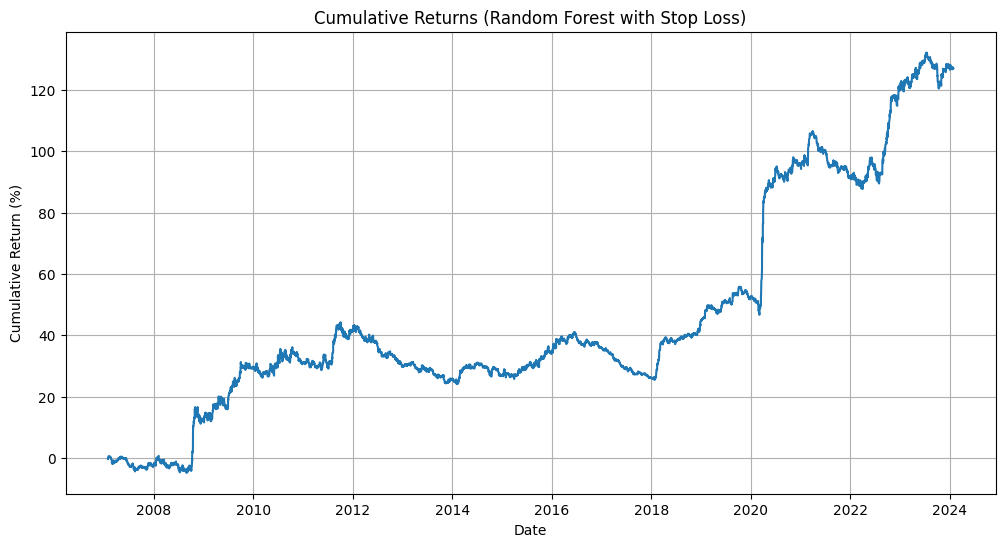

Final Cumulative Compounded Return: 126.99%

Overall Test Accuracy : 49.01%
Overall Precision     : 32.59%
Overall Recall        : 33.60%
Overall F1 Score      : 33.04%
Overall ROC AUC       : 53.30%

Average Fold Test Return : 0.01224%

Standard Deviation of All Test Returns (Aggregated Daily): 0.26049%

Minimum Return (Aggregated Daily): -0.97867%

Optimal Horizon Counts:
_double     15
standard     2
Name: count, dtype: int64

Test Set Position Counts:
Neutral (0): 0
Long (1): 8089
Short (2): 6617


In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['PYTHONHASHSEED'] = '0'

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score
)
import numpy as np
import pandas as pd
import random

# --- Configuration ---
total_cost = 2 * transaction_cost
horizons = ['', '_half', '_double']

# --- Data Prep ---
df_ml = df_ml.dropna(subset=['Surprise']).sort_values('DateTime')
min_date = df_ml['DateTime'].min()
max_date = df_ml['DateTime'].max()

# --- Calculate Initial 30% Training Period ---
total_duration = max_date - min_date
initial_train_duration = total_duration * 0.3
train_end_date = min_date + initial_train_duration

# --- Tracking containers ---
results = []
all_test_returns = []
all_dates = []
all_test_preds = []
all_test_truths = []
all_test_probas = []
fold_mean_returns = []
best_horizons_list = []

def calculate_grouped_returns(df_group, horizon, stop_loss=None):
    """Calculate returns with position sizing and stop loss"""
    active_trades = df_group[df_group['pred'] != 0]
    if active_trades.empty:
        return 0.0

    # Create copies with reset index
    longs = active_trades[active_trades['pred'] == 1].copy().reset_index(drop=True)
    shorts = active_trades[active_trades['pred'] == 2].copy().reset_index(drop=True)

    total_confidence = longs['proba'].sum() + shorts['proba'].sum()
    if total_confidence == 0:
        return 0.0

    num_trades = len(longs) + len(shorts)
    total_costs = total_cost * num_trades

    long_returns = 0.0
    short_returns = 0.0

    # Process longs with reset index
    if not longs.empty:
        long_weights = longs['proba'] / total_confidence
        for idx in longs.index:
            raw_return = longs.loc[idx, f'Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            long_returns += capped_raw * long_weights.loc[idx]

    # Process shorts with reset index
    if not shorts.empty:
        short_weights = shorts['proba'] / total_confidence
        for idx in shorts.index:
            raw_return = -shorts.loc[idx, f'Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            short_returns += capped_raw * short_weights.loc[idx]

    net_return = (long_returns + short_returns) - total_costs
    return net_return

# --- Main Loop ---
while True:
    val_start_date = train_end_date + pd.DateOffset(days=1)
    val_end_date = val_start_date + pd.DateOffset(years=1)
    test_start_date = val_end_date + pd.DateOffset(days=1)
    test_end_date = test_start_date + pd.DateOffset(years=1)

    if val_end_date > max_date or test_end_date > max_date:
        break

    train_mask = df_ml['DateTime'] <= train_end_date
    val_mask = (df_ml['DateTime'] >= val_start_date) & (df_ml['DateTime'] <= val_end_date)
    test_mask = (df_ml['DateTime'] >= test_start_date) & (df_ml['DateTime'] <= test_end_date)

    train_data = df_ml[train_mask]
    val_data = df_ml[val_mask]
    test_data = df_ml[test_mask]

    if val_data.empty or test_data.empty:
        print(f"Skipping period {val_start_date.date()} to {test_end_date.date()} (no data)")
        train_end_date += pd.DateOffset(years=1)
        continue

    # --- Horizon Optimization ---
    best_horizon, best_model, best_stop_loss = None, None, None
    best_val_return = -np.inf

    for horizon in horizons:
        # Feature scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[feature_cols])
        X_val = scaler.transform(val_data[feature_cols])
        y_train = train_data[f'Profit{horizon}']
        y_val = val_data[f'Profit{horizon}']

        # Train model
        model = RandomForestClassifier(
            n_estimators=100,
            criterion='gini',
            min_samples_leaf=4,
            random_state=42
        )
        model.fit(X_train, y_train)

        # Get class probabilities
        train_preds = model.predict(X_train)
        train_probas = model.predict_proba(X_train)
        class_map = {cls: idx for idx, cls in enumerate(model.classes_)}

        # Training stop loss calculation
        train_trade_df = pd.DataFrame({
            'DateTime': train_data['DateTime'],
            'pred': train_preds,
            'proba': [proba[class_map[pred]] for pred, proba in zip(train_preds, train_probas)],
            f'Return{horizon}': train_data[f'Return{horizon}']
        })

        train_raw_returns = []
        for _, row in train_trade_df.iterrows():
            if row['pred'] == 1:
                train_raw_returns.append(row[f'Return{horizon}'])
            elif row['pred'] == 2:
                train_raw_returns.append(-row[f'Return{horizon}'])
        stop_loss_train = np.percentile(train_raw_returns, 5) if train_raw_returns else None

        # Validation predictions
        val_preds = model.predict(X_val)
        val_probas = model.predict_proba(X_val)
        val_trade_df = pd.DataFrame({
            'DateTime': val_data['DateTime'],
            'pred': val_preds,
            'proba': [proba[class_map[pred]] for pred, proba in zip(val_preds, val_probas)],
            f'Return{horizon}': val_data[f'Return{horizon}']
        })

        # Validation stop loss calculation (for test set)
        val_raw_returns = []
        for _, row in val_trade_df.iterrows():
            if row['pred'] == 1:
                val_raw_returns.append(row[f'Return{horizon}'])
            elif row['pred'] == 2:
                val_raw_returns.append(-row[f'Return{horizon}'])
        stop_loss_val = np.percentile(val_raw_returns, 5) if val_raw_returns else None

        # Validate using training stop loss
        val_returns = val_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, horizon, stop_loss_train)
        ).values

        total_val_return = (1 + val_returns).prod() - 1

        if total_val_return > best_val_return:
            best_val_return = total_val_return
            best_horizon = horizon
            best_model = model
            best_stop_loss = stop_loss_val

    # --- Test Best Model ---
    if best_model and best_stop_loss is not None:
        X_test = scaler.transform(test_data[feature_cols])
        test_preds = best_model.predict(X_test)
        test_probas = best_model.predict_proba(X_test)
        y_test = test_data[f'Profit{best_horizon}'].values

        class_map = {cls: idx for idx, cls in enumerate(best_model.classes_)}
        test_trade_df = pd.DataFrame({
            'DateTime': test_data['DateTime'],
            'pred': test_preds,
            'proba': [proba[class_map[pred]] for pred, proba in zip(test_preds, test_probas)],
            f'Return{best_horizon}': test_data[f'Return{best_horizon}']
        })

        grouped_returns = test_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, best_horizon, best_stop_loss)
        ).values

        all_test_returns.extend(grouped_returns)
        all_dates.extend(test_trade_df['DateTime'].unique().tolist())
        all_test_preds.extend(test_preds)
        all_test_truths.extend(y_test)
        all_test_probas.append(test_probas)
        fold_mean_returns.append(np.mean(grouped_returns))
        best_horizons_list.append(best_horizon or 'standard')

    train_end_date += pd.DateOffset(years=1)

# --- Results ---
if all_test_returns:
    cumulative_returns = (1 + np.array(all_test_returns)).cumprod() - 1
    std_dev_individual = np.std(all_test_returns) * 100
    min_return = np.nanmin(all_test_returns) * 100 if all_test_returns else 0.0

    plt.figure(figsize=(12, 6))
    plt.plot(all_dates, cumulative_returns * 100)
    plt.title('Cumulative Returns (Random Forest with Stop Loss)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.show()

    print(f"Final Cumulative Compounded Return: {cumulative_returns[-1]*100:.2f}%")
    print(f"\nOverall Test Accuracy : {accuracy_score(all_test_truths, all_test_preds)*100:.2f}%")
    print(f"Overall Precision     : {precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall Recall        : {recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall F1 Score      : {f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall ROC AUC       : {roc_auc_score(all_test_truths, np.vstack(all_test_probas), multi_class='ovo', average='macro')*100:.2f}%")
    print(f"\nAverage Fold Test Return : {np.mean(fold_mean_returns)*100:.5f}%")
    print(f"\nStandard Deviation of All Test Returns (Aggregated Daily): {std_dev_individual:.5f}%")
    print(f"\nMinimum Return (Aggregated Daily): {min_return:.5f}%")
    print("\nOptimal Horizon Counts:")
    print(pd.Series(best_horizons_list).value_counts())
    print("\nTest Set Position Counts:")
    counts = pd.Series(all_test_preds).value_counts().sort_index()
    print(f"Neutral (0): {counts.get(0, 0)}")
    print(f"Long (1): {counts.get(1, 0)}")
    print(f"Short (2): {counts.get(2, 0)}")

else:
    print("No valid test periods found")

In [ ]:
# RF confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Add this after your existing print statements
print("\nConfusion Matrix:")
cm = confusion_matrix(all_test_truths, all_test_preds)
cm_df = pd.DataFrame(cm,
                    index=['Actual Neutral (0)', 'Actual Long (1)', 'Actual Short (2)'],
                    columns=['Pred Neutral (0)', 'Pred Long (1)', 'Pred Short (2)'])
print(cm_df)

print("\nClassification Report:")
print(classification_report(all_test_truths, all_test_preds,
                           target_names=['Neutral (0)', 'Long (1)', 'Short (2)']))


Confusion Matrix:
                    Pred Neutral (0)  Pred Long (1)  Pred Short (2)
Actual Neutral (0)                 0            238             204
Actual Long (1)                    0           4057            3262
Actual Short (2)                   0           3794            3151

Classification Report:
              precision    recall  f1-score   support

 Neutral (0)       0.00      0.00      0.00       442
    Long (1)       0.50      0.55      0.53      7319
   Short (2)       0.48      0.45      0.46      6945

    accuracy                           0.49     14706
   macro avg       0.33      0.34      0.33     14706
weighted avg       0.47      0.49      0.48     14706



c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

<h1>Final Logistic Regression</h1>

In [ ]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score
)
import numpy as np
import pandas as pd
import os, random

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# --- Configuration ---
total_cost = 2 * transaction_cost  # Total cost per trade (entry + exit)
horizons = ['', '_half', '_double']

# --- Data Prep ---
df_ml = df_ml.dropna(subset=['Surprise']).sort_values('DateTime')
min_date = df_ml['DateTime'].min()
max_date = df_ml['DateTime'].max()

# --- Calculate Initial 30% Training Period ---
total_duration = max_date - min_date
initial_train_duration = total_duration * 0.3
train_end_date = min_date + initial_train_duration

# --- Tracking containers ---
all_test_returns = []
all_dates = []
all_test_preds = []
all_test_truths = []
all_test_probas = []
fold_mean_returns = []
best_horizons_list = []

def calculate_grouped_returns(df_group, horizon, stop_loss=None):
    """Calculate returns with position sizing and stop loss"""
    active_trades = df_group[df_group['pred'] != 0]
    if active_trades.empty:
        return 0.0

    # Create copies with reset index
    longs = active_trades[active_trades['pred'] == 1].copy().reset_index(drop=True)
    shorts = active_trades[active_trades['pred'] == 2].copy().reset_index(drop=True)

    total_confidence = longs['proba'].sum() + shorts['proba'].sum()
    if total_confidence == 0:
        return 0.0

    num_trades = len(longs) + len(shorts)
    total_costs = total_cost * num_trades

    long_returns = 0.0
    short_returns = 0.0

    # Process longs with capping
    if not longs.empty:
        long_weights = longs['proba'] / total_confidence
        for idx in longs.index:
            raw_return = longs.loc[idx, f'Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            long_returns += capped_raw * long_weights.loc[idx]

    # Process shorts with capping
    if not shorts.empty:
        short_weights = shorts['proba'] / total_confidence
        for idx in shorts.index:
            raw_return = -shorts.loc[idx, f'Return{horizon}']
            capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
            short_returns += capped_raw * short_weights.loc[idx]

    net_return = (long_returns + short_returns) - total_costs
    return net_return

# --- Main Loop ---
while True:
    val_start_date = train_end_date + pd.DateOffset(days=1)
    val_end_date = val_start_date + pd.DateOffset(years=1)
    test_start_date = val_end_date + pd.DateOffset(days=1)
    test_end_date = test_start_date + pd.DateOffset(years=1)

    if val_end_date > max_date or test_end_date > max_date:
        break

    train_mask = df_ml['DateTime'] <= train_end_date
    val_mask = (df_ml['DateTime'] >= val_start_date) & (df_ml['DateTime'] <= val_end_date)
    test_mask = (df_ml['DateTime'] >= test_start_date) & (df_ml['DateTime'] <= test_end_date)

    train_data = df_ml[train_mask]
    val_data = df_ml[val_mask]
    test_data = df_ml[test_mask]

    if val_data.empty or test_data.empty:
        print(f"Skipping period {val_start_date.date()} to {test_end_date.date()} (no data)")
        train_end_date += pd.DateOffset(years=1)
        continue

    # --- Horizon Optimization ---
    best_horizon, best_model, best_stop_loss = None, None, None
    best_val_return = -np.inf

    for horizon in horizons:
        # Feature scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[feature_cols])
        X_val = scaler.transform(val_data[feature_cols])
        y_train = train_data[f'Profit{horizon}']
        y_val = val_data[f'Profit{horizon}']

        # Train Logistic Regression
        model = LogisticRegression(
            multi_class='multinomial',
            solver='saga',
            max_iter=100,
            random_state=42
        )
        model.fit(X_train, y_train)

        # Training stop loss calculation
        train_preds = model.predict(X_train)
        train_probas = model.predict_proba(X_train)
        class_map = {cls: idx for idx, cls in enumerate(model.classes_)}

        train_trade_df = pd.DataFrame({
            'DateTime': train_data['DateTime'],
            'pred': train_preds,
            'proba': [proba[class_map[pred]] for pred, proba in zip(train_preds, train_probas)],
            f'Return{horizon}': train_data[f'Return{horizon}']
        })

        train_raw_returns = []
        for _, row in train_trade_df.iterrows():
            if row['pred'] == 1:
                train_raw_returns.append(row[f'Return{horizon}'])
            elif row['pred'] == 2:
                train_raw_returns.append(-row[f'Return{horizon}'])
        stop_loss_train = np.percentile(train_raw_returns, 5) if train_raw_returns else None

        # Validation predictions and stop loss
        val_preds = model.predict(X_val)
        val_probas = model.predict_proba(X_val)
        val_trade_df = pd.DataFrame({
            'DateTime': val_data['DateTime'],
            'pred': val_preds,
            'proba': [proba[class_map[pred]] for pred, proba in zip(val_preds, val_probas)],
            f'Return{horizon}': val_data[f'Return{horizon}']
        })

        val_raw_returns = []
        for _, row in val_trade_df.iterrows():
            if row['pred'] == 1:
                val_raw_returns.append(row[f'Return{horizon}'])
            elif row['pred'] == 2:
                val_raw_returns.append(-row[f'Return{horizon}'])
        stop_loss_val = np.percentile(val_raw_returns, 5) if val_raw_returns else None

        # Validate using training stop loss
        val_returns = val_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, horizon, stop_loss_train)
        ).values

        total_val_return = (1 + val_returns).prod() - 1

        if total_val_return > best_val_return:
            best_val_return = total_val_return
            best_horizon = horizon
            best_model = model
            best_stop_loss = stop_loss_val

    # --- Test Best Model ---
    if best_model and best_stop_loss is not None:
        X_test = scaler.transform(test_data[feature_cols])
        test_preds = best_model.predict(X_test)
        test_probas = best_model.predict_proba(X_test)
        y_test = test_data[f'Profit{best_horizon}'].values

        class_map = {cls: idx for idx, cls in enumerate(best_model.classes_)}
        test_trade_df = pd.DataFrame({
            'DateTime': test_data['DateTime'],
            'pred': test_preds,
            'proba': [proba[class_map[pred]] for pred, proba in zip(test_preds, test_probas)],
            f'Return{best_horizon}': test_data[f'Return{best_horizon}']
        })

        grouped_returns = test_trade_df.groupby('DateTime').apply(
            lambda x: calculate_grouped_returns(x, best_horizon, best_stop_loss)
        ).values

        all_test_returns.extend(grouped_returns)
        all_dates.extend(test_trade_df['DateTime'].unique().tolist())
        all_test_preds.extend(test_preds)
        all_test_truths.extend(y_test)
        all_test_probas.append(test_probas)
        fold_mean_returns.append(np.mean(grouped_returns))
        best_horizons_list.append(best_horizon or 'standard')

    train_end_date += pd.DateOffset(years=1)

# --- Results ---
if all_test_returns:
    cumulative_returns = (1 + np.array(all_test_returns)).cumprod() - 1
    std_dev_individual = np.std(all_test_returns) * 100
    min_return = np.nanmin(all_test_returns) * 100 if all_test_returns else 0.0

    plt.figure(figsize=(12, 6))
    plt.plot(all_dates, cumulative_returns * 100)
    plt.title('Cumulative Returns (Logistic Regression with Stop Loss)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.show()

    print(f"Final Cumulative Compounded Return: {cumulative_returns[-1]*100:.2f}%")
    print(f"\nOverall Test Accuracy : {accuracy_score(all_test_truths, all_test_preds)*100:.2f}%")
    print(f"Overall Precision     : {precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall Recall        : {recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall F1 Score      : {f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
    print(f"Overall ROC AUC       : {roc_auc_score(all_test_truths, np.vstack(all_test_probas), multi_class='ovo', average='macro')*100:.2f}%")
    print(f"\nAverage Fold Test Return : {np.mean(fold_mean_returns)*100:.5f}%")
    print(f"\nStandard Deviation of All Test Returns (Aggregated Daily): {std_dev_individual:.5f}%")
    print(f"\nMinimum Return (Aggregated Daily): {min_return:.5f}%")
    print("\nOptimal Horizon Counts:")
    print(pd.Series(best_horizons_list).value_counts())
    print("\nTest Set Position Counts:")
    counts = pd.Series(all_test_preds).value_counts().sort_index()
    print(f"Neutral (0): {counts.get(0, 0)}")
    print(f"Long (1): {counts.get(1, 0)}")
    print(f"Short (2): {counts.get(2, 0)}")

else:
    print("No valid test periods found")

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# LR confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Add this after your existing print statements
print("\nConfusion Matrix:")
cm = confusion_matrix(all_test_truths, all_test_preds)
cm_df = pd.DataFrame(cm,
                    index=['Actual Neutral (0)', 'Actual Long (1)', 'Actual Short (2)'],
                    columns=['Pred Neutral (0)', 'Pred Long (1)', 'Pred Short (2)'])
print(cm_df)

print("\nClassification Report:")
print(classification_report(all_test_truths, all_test_preds,
                           target_names=['Neutral (0)', 'Long (1)', 'Short (2)']))